In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score

In [2]:
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r

def bit_error_rate(y_test, y_pred):
    pred = ''.join([f"{sym:04b}" for sym in y_test])
    test = ''.join([f"{sym:04b}" for sym in y_pred])

    test = np.array(list(test))
    pred = np.array(list(pred))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(test, pred):
        if i != j:
            ber += 1
    
    return ber/len(test)

In [3]:
np.random.seed(0)
Ns = 10000
n = 16
y = np.random.randint(n, size=Ns)

In [4]:
mod_dict = {0: -3+3j,  # 0000
            1: -3+1j,  # 0001
            2: -3-3j,  # 0010
            3: -3-1j,  # 0011
            4: -1+3j,  # 0100
            5: -1+1j,  # 0101
            6: -1-3j,  # 0110
            7: -1-1j,  # 0111
            8: 3+3j,  # 1000
            9: 3+1j,  # 1001
            10: 3-3j,  # 1010
            11: 3-1j,  # 1011
            12: 1+3j,  # 1100
            13: 1+1j,  # 1101
            14: 1-3j,  # 1110
            15: 1-1j}  # 1111

In [5]:
syms_rx = np.array([mod_dict[mod] for mod in y])

In [6]:
OSNR = [12, 13, 14, 15, 16, 17, 18, 19]
Xr = np.array([add_noise(np.real(syms_rx), noise) for noise in OSNR])
Xi = np.array([add_noise(np.imag(syms_rx), noise) for noise in OSNR])
#X = np.array([np.array([r, i]).T for r, i in zip(Xr, Xi)])

In [7]:
df = pd.DataFrame()
for i in range(len(OSNR)):
    df[f'X{i}'] = Xr[i]+1j*Xi[i]
df['y'] = y
df = df.sort_values(by=['y'])
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,y
9999,-2.858474+2.840033j,-2.781765+3.224732j,-3.011355+2.187523j,-2.584221+2.574191j,-2.403646+2.980267j,-2.944942+3.250967j,-2.743813+2.888679j,-2.929465+2.891336j,0
7003,-2.802948+2.055044j,-3.245993+2.180831j,-4.327415+2.328967j,-2.553808+3.382383j,-3.182698+3.265650j,-2.959870+2.906781j,-3.198388+2.644417j,-3.173782+2.674458j,0
2671,-3.768143+2.565915j,-2.605935+2.915501j,-2.546327+3.823926j,-3.234193+2.413127j,-3.087522+2.987317j,-3.646638+3.011209j,-2.956401+2.616516j,-2.723161+2.809223j,0
2664,-3.582323+2.662800j,-2.995553+2.547181j,-2.636841+3.237339j,-3.479831+2.364495j,-2.746874+2.608615j,-3.170076+3.215608j,-2.803985+2.928363j,-2.899073+2.960083j,0
9325,-2.094065+3.821894j,-3.553889+3.048890j,-2.513887+2.624608j,-3.107944+2.588637j,-2.670400+3.124342j,-2.882102+2.986776j,-3.030219+3.529825j,-3.443583+3.368147j,0


In [8]:
Xr = np.array([np.real(df[f'X{i}']) for i in range(len(OSNR))])
Xi = np.array([np.imag(df[f'X{i}']) for i in range(len(OSNR))])
X = np.array([np.array([r, i]).T for r, i in zip(Xr, Xi)])

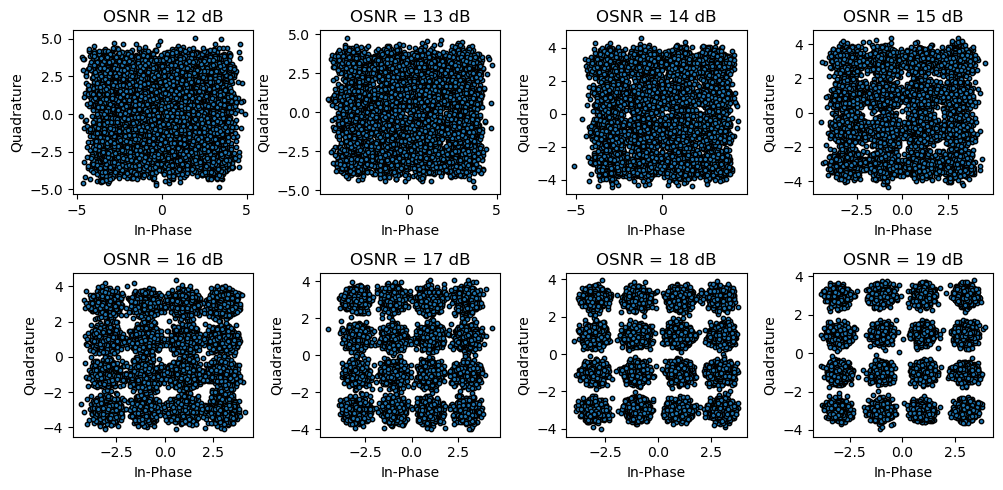

In [9]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], s=10, edgecolors='black')
    plt.title(f'OSNR = {OSNR[i]} dB')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
plt.tight_layout()
plt.show()

In [10]:
dbscan = DBSCAN(eps=0.5, min_samples=100)
ber = []
acc = []
for i in range(len(OSNR)):
    dbscan.fit(X[i])
    labels = dbscan.labels_
    ber.append(bit_error_rate(df['y'], labels))
    acc.append(accuracy_score(df['y'], labels)*100)

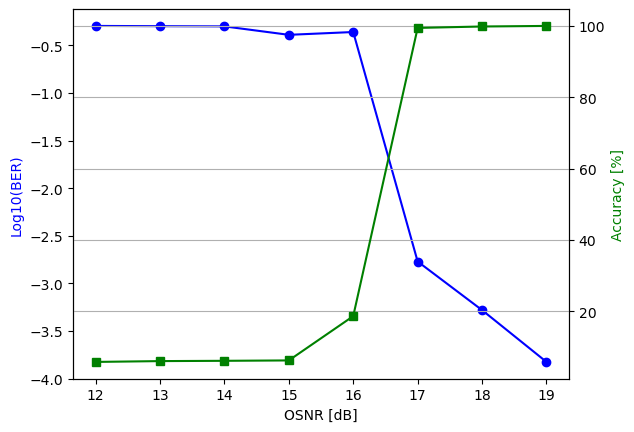

In [11]:
fig, ax1 = plt.subplots()
ax1.plot(OSNR, np.log10(ber), 'bo-')
ax1.set_xlabel('OSNR [dB]')
ax1.set_ylabel('Log10(BER)', color='b')

ax2 = ax1.twinx()
ax2.plot(OSNR, acc, 'gs-')
ax2.set_ylabel('Accuracy [%]', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()